# Test effect of frequency of reconsolidation

Rather than changing the drift rate, we change the frequeny at which the self-healing reconsolidation is run relative to the drift rate.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

'''
We need to use start-method 'spawn' or 'forkserver' for compatability
with Jax. 'forkserver' is allegedly faster. Spawn/forkserver starts 
each worker from a clean state. Code and data required to compute the 
job are serialized and sent to the worker. Functions being run should
be class methods (easily serialized). Any static initialization must
be done again, manually, in each worker process. We also need to use
multiprocess rather than multiprocessing to get around picking errors.
(Multiprocess uses  'dill' instead of pickle). When working on a 
remote server, workers should only print ASCII-compatible outputs to 
avoid unicode encoding errors in the worker processes. Also note that
both Jax and Multiprocessing will fail if the process IDs on the host
system have been exhausted, with obscure errors. 
'''
import multiprocess as multi
try:
    multi.set_start_method('spawn')
except RuntimeError:
    print('couldn\'t set context')
    
import config, master, standard_options
from config           import *
from master           import *
from standard_options import *

import parallel
from parallel import _parmap, helper, try_variations, methods, method_names

# If runnign parallel jobs, limit cores/job to 1
# Disable logging (too verbose)
limit_cores()
debug = False
master.PRINT_LOGGING = not debug

from itertools import product
import copy as cpy
cm = cpy.copy(matplotlib.cm.get_cmap('bone_r'))
cm.set_bad(color='m')

In [7]:
T    = options['T']
Δs   = [5,10,15,20,25,30,35,40,45]
jobs = []
o    = {**options, 'T':T, 'saveall':True, 'features':'ougaussian'}
geometries = ('ring','line','tee')
for seed in range(20):
    for t in geometries:
        for Δ in Δs: 
            ot = {**o,'geometry':t, 'readout':t, 'seed':seed, 'Δ':Δ}
            jobs += [
                {**ot, 'method':'hebbhomeo' , 'normalize':False, **hebb_rates },
                {**ot, 'method':'hebbhomeo' , 'normalize':True , **hebb_rates },
                {**ot, 'method':'recurrent' , 'normalize':True , **map_rates  },
                {**ot, 'method':'predictive', 'normalize':True , **feedback_rates}
            ]
results =  _parmap(helper,jobs,debug=False)
pop_hebbhomeo  = results[0::4]
pop_normalize  = results[1::4]
pop_recurrent  = results[2::4]
pop_predictive = results[3::4]
notify('driftrate sims done')

Shuffling job sequence
Preparing to run 2160 jobs
Starting...
[████████████████████████████████████████]100.000% 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

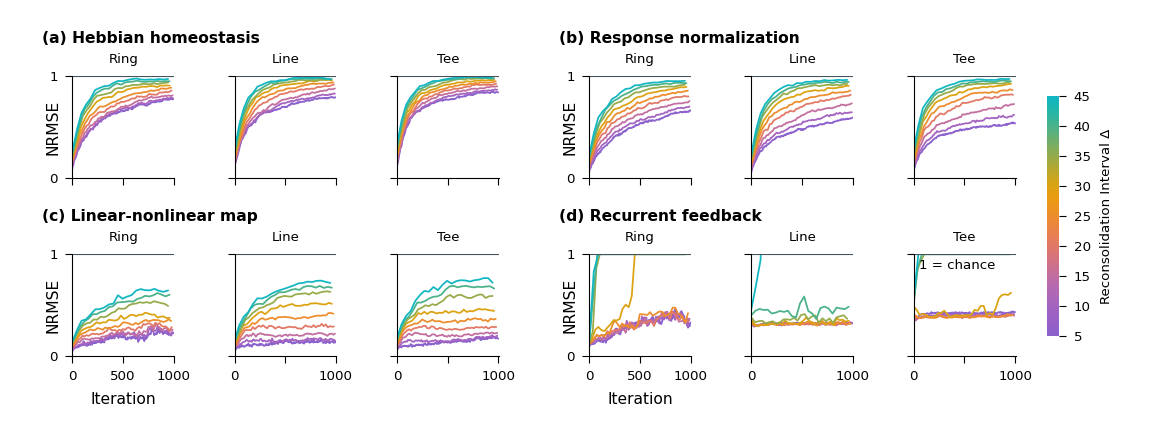

In [8]:
titles = [
    'Hebbian homeostasis',
    'Response normalization',
    'Linear-nonlinear map',
    'Recurrent feedback',
]

nd = len(Δs)

figure(figsize=(PNAS_LARGE_WIDTH,2.5),dpi=160)

subplots_adjust(left=0.04,right=0.875,bottom=0.15,wspace=.3,hspace=.75,top=0.85)

xt = [0,500,1000]

axs = {}

for j,pop in enumerate([pop_hebbhomeo, pop_normalize, pop_recurrent, pop_predictive]):
    for it,geometry in enumerate(geometries):
        axs[j,it] = subplot2grid((2,6),(j//2,3*(j%2)+it))
        for i,Δ in enumerate(Δs):
            q = []
            for seed in range(20):
                W,X,Y,Z,U,R,G,B = pop[i + it*len(Δs) + seed*len(Δs)*len(geometries)]
                q.append(summarize_stability(Z,Y))
            q = median(nan_to_num(array(q),nan=1,posinf=1),0)
            tt = arange(q.shape[0])*Δ
            plot(tt,q,color=riley(.8*i/nd),label='Δ=%d'%Δ,lw=0.8)
        ylim(0,1)
        axhline(1,lw=lw,color=BLACK)
        simpleaxis(); xlim(0,T); yticks([0,1])
        if it==0: yticks([0,1]); ylabel('NRMSE'); fudgey(5);
        else:     yticks([0,1],['','']);
        if j in (2,3):
            if it==0: xlabel('Iteration'); xticks(xt);
            else:     xticks(xt,[str(xt[0])]+['']*(len(xt)-2)+[str(xt[-1])]);
        else:
            xticks(xt,('',)*len(xt))
        title(geometry.title(),fontsize=SMALL)
        force_aspect()

[nudge_axis_x(30,axs[j,it]) 
 for j in (1,3) for it in range(3)[::-1]]

[subfigurelabel('(%s) %s'%('abcd'[j],titles[j]),MEDIUM,30,30,axs[j,0]) 
 for j in range(4)]
        
sca(axs[3,2])
text(0+px2x(5),1-px2y(5),'1 = chance',fontsize=SMALL, va = 'top')
figurebox('w')

gcf().add_axes([.9,.2,.05,.6])
imshow(array([riley(linspace(0,.8*i/nd,100))]).transpose(1,0,2),extent=(0,1,Δs[0],Δs[-1]),aspect=0.5)
noxyaxes()
ylabel('Reconsolidation Interval Δ',fontsize=SMALL)
gca().yaxis.set_label_position("right")
gca().yaxis.tick_right()
yticks(Δs);

savefigure('s5.pdf',stamp=False)
notify('rate scaling plotted')